<a href="https://colab.research.google.com/github/a-woodbury/RxVision/blob/master/Notebooks/rxv_vgg16_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Environment Prep

### Package Import

In [0]:
import imageio
import imgaug as ia

import pandas as pd
import numpy as np
import pickle
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings('ignore')
#!{sys.executable} -m pip install opencv-python

import time
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

#import tensorflow as tf
#from tensorflow import keras

import scipy
from PIL import Image
from scipy import ndimage

#import tensorflow as tf
#from tensorflow import keras
import tensorflow.keras 
from keras import layers
from keras import models
from keras import optimizers
from keras import models
from keras import layers
import multiprocessing

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.applications.resnet import ResNet50
from keras.callbacks import CSVLogger

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV, validation_curve 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import make_pipeline
#from tensorflow.keras import get_default_graph

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# This code has been tested with TensorFlow 1.6
#import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
np.random.seed(123)

# Transfer learning with VGG16
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input

import random 

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn import metrics
import seaborn as sns

from numpy import loadtxt
from keras.models import load_model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import warnings
warnings.filterwarnings('ignore')

import datetime as dt
import time
import itertools

from PIL import Image
from scipy import ndimage

import tensorflow.keras 
from keras import layers
from keras import models
from keras import optimizers

import multiprocessing

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model
from keras.models import load_model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from PIL import ImageFile

np.random.seed(123)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## Functions

In [0]:
def model_scores(model):
  '''Return validation accuracy and real-world accuracy after evaluating provided model'''
  model_val_results = model.evaluate(val_generator)
  modelacc = model_val_results[1]
  model_rw_results = model.evaluate(realworld_generator)
  modelrw = model_rw_results[1]
  print('\nValidation Accuracy: ' + str(int(modelacc*100)) + '%' + '\nReal-world Accuracy: ' + str(int(modelrw*100)) + '%')

def model_acc_val_plot(model):
  '''Return train and validation loss and accuracy plots from hist log'''
  class_size =  int(val_generator.samples / len(val_generator.class_indices))
  acc = hist['acc']
  val_acc = hist['val_acc']

  loss = hist['loss']
  val_loss = hist['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(0,len(hist)), acc, label='Training Accuracy')
  plt.plot(range(0,len(hist)), val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(range(0,len(hist)), loss, label='Training Loss')
  plt.plot(range(0,len(hist)), val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('/content/drive/My Drive/RxID2/Images/{}_AccLoss.png'.format(model.name))
  plt.show()

def model_confusion(model):
  '''Return a confusion matrix for predictions made from evaluating the proviced model'''
  labels = list((val_generator.class_indices).values())
  pred = model.predict(val_generator)
  y_pred=np.argmax(pred,axis=1)
  y_true = val_generator.classes

  cf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=labels)

  fig, ax = plt.subplots(figsize=(8,6.75))  
  pal = sns.light_palette("#ffab40", as_cmap=True)
  sns.heatmap(cf_matrix, annot=True,cmap=pal,ax=ax)
  plt.ylabel('Class Actual', fontweight='bold')
  plt.xlabel('Class Predicted', fontweight='bold')
  plt.title('/content/drive/My Drive/RxID2/Images/{}_Confusion Matrix'.format(model.name), fontweight='bold', loc='left')
  plt.savefig('/content/drive/My Drive/RxID2/Images/{}_conf'.format(model.name))

def predict_plot(model):
  '''
  Return an image plot with class, number of correct predictions,
  and predicted classes (ordered by descending frequency)
  '''
  %cd /content/drive/My Drive/RxID2/Data/Download
  labels = list((val_generator.class_indices).values())
  pred = model.predict(val_generator)
  y_pred=np.argmax(pred,axis=1)
  y_true = val_generator.classes
  class_size =  int(val_generator.samples / len(val_generator.class_indices))
  dfx = df[df.TYPE == 'MC_COOKED_CALIBRATED_V1.2']
  samplesdfx = dfx.groupby(['NDC']).min().reset_index()
  sampleslist2 = samplesdfx.FILE.tolist()
  #len(sampleslist2)

  samplefiles = []
  for image in sampleslist2:
      smplsplt = image.split('/')
      keep = smplsplt[-1]
      keep = keep[:-4]
      keep= keep +('.JPG')
      samplefiles.append(keep)

      
  #for file in os.listdir():
  drgimg = os.listdir()
  images = []
  for file in samplefiles:
      data = plt.imread(file)
      images.append(data)
  plt.figure(figsize=(15,15))
  columns = 5

  for i, image in enumerate(images): # iterate through the images in the array 'images'
      k = i * class_size
      j = (i + 1) * class_size
      trues = int(y_true[k:j].mean())
      preds = list(y_pred[k:j]).count(trues)
      lst = list(y_pred[k:j])
      preddict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0}
      for pred in lst:
          preddict[pred] +=1
      preddict = {k: v for k, v in sorted(preddict.items(), key=lambda item: item[1], reverse=True)}
      for k, v in list(preddict.items()):
          if v == 0:
              del preddict[k]
      predlist = list(preddict.keys())
      dname = df.DRUG[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the drug name from the df for the image in index i 
      dndc = df.NDC[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the NDC from the df for the image in index i 
      title = '[' + str(i) + '] ' + ' ' + dname + '\nCorrect: ' + str(preds) + '\nPreds: ' +  ', '.join(map(str,predlist)) # title for each subplot: class, drug name, and NDC
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.suptitle('RxID15 Classes',fontweight='bold',fontsize='large', color= '#ffab40')
      plt.subplots_adjust(hspace=0.2,wspace=0.25, top=.9, bottom=.2) # i believe this is the subplots spacing from each other and within the plot
      plt.margins(tight=True) # not sure which margins this is impacting
      plt.title(title,fontweight='semibold',fontsize='10')
      plt.imshow(image)
      plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
      plt.savefig('/content/drive/My Drive/RxID2/Images/{}_predictions.jpg'.format(model.name),format='jpg',quality=95,dpi=300, bbox='tight',pad_inches = 0) # bbox has always given me the output i wanted...
  %cd ../..

def real_world_predicts(model):
  '''Return predicted classes for real world images using provided model'''
  pred = model.predict(realworld_generator)
  y_pred=np.argmax(pred,axis=1)
  print('\nReal-world predictions 0-14: ', y_pred)

## Data Prep

### Data import

In [0]:
df = pd.read_csv('/content/drive/My Drive/RxID2/Data/rxid15.csv')

In [0]:
train_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/train'
val_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/validation'
realworld_folder = '/content/drive/My Drive/RxID2/Data/RxID2_split/realworld2'

In [7]:
BATCH_SIZE = 24
IMG_SHAPE  = 224 
EPOCHS = 100 

realworld_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(realworld_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       shuffle=False,
                                                                       class_mode='categorical',
                                                                       target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                       batch_size = BATCH_SIZE)

train_generator = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     brightness_range=(.5,1.5),
                                     shear_range=0.2,
                                     #channel_shift_range=128,
                                     rotation_range=45,
                                     vertical_flip=True,
                                     #fill_mode="nearest",
                                     zoom_range=0.35).flow_from_directory(train_folder,
                                                                          shuffle=True,
                                                                          class_mode='categorical',
                                                                          target_size=(IMG_SHAPE,IMG_SHAPE),
                                                                          batch_size=BATCH_SIZE)

Found 15 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


In [16]:
from keras.applications import VGG16
cnn_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SHAPE ,IMG_SHAPE,  3))
cnn_model.trainable = True


model = models.Sequential(name='rxv_vgg16_2')

model.add(cnn_model)
model.add(layers.MaxPooling2D((3, 3)))


model.add(layers.Conv2D(1024, (3,3), activation='relu', padding="same"))
#model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.01))

model.add(layers.Conv2D(512, (3,3), activation='relu', padding="same"))
#model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.005))

model.add(layers.Conv2D(256, (3,3), activation='relu', padding="same"))
model.add(layers.GaussianNoise(3.0))

model.add(layers.Flatten())
model.add(layers.Dense(15, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
model.summary()

Model: "rxv_vgg16_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 2, 2, 1024)        4719616   
_________________________________________________________________
dropout_11 (Dropout)         (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 2, 2, 512)         4719104   
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 2, 2, 256)         

In [17]:
csv_logger = CSVLogger('/content/drive/My Drive/RxID2/Models/hist_{}.log'.format(model.name), separator=',', append=False)


#checkpoint = ModelCheckpoint("../Models/{}{}.h5".format(model.name,random.randint(1,10000)), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    callbacks=[early,csv_logger],
                    verbose=1,
                    use_multiprocessing=True,
                    workers=multiprocessing.cpu_count())
model.save('/content/drive/My Drive/RxID2/Models/model_{}'.format(model.name))

Epoch 1/100
13/13 [==============================] - 47s 4s/step - loss: 7.8979 - acc: 0.0567 - val_loss: 2.9046 - val_acc: 0.1333
Epoch 2/100
13/13 [==============================] - 43s 3s/step - loss: 7.2215 - acc: 0.0900 - val_loss: 3.5729 - val_acc: 0.2800
Epoch 3/100
13/13 [==============================] - 43s 3s/step - loss: 6.2106 - acc: 0.1533 - val_loss: 0.6911 - val_acc: 0.4400
Epoch 4/100
13/13 [==============================] - 43s 3s/step - loss: 5.0228 - acc: 0.2600 - val_loss: 2.5320 - val_acc: 0.5067
Epoch 5/100
13/13 [==============================] - 43s 3s/step - loss: 4.3291 - acc: 0.3333 - val_loss: 0.0937 - val_acc: 0.5200
Epoch 6/100
13/13 [==============================] - 43s 3s/step - loss: 4.0847 - acc: 0.3833 - val_loss: 0.0032 - val_acc: 0.4933
Epoch 7/100
13/13 [==============================] - 43s 3s/step - loss: 3.5531 - acc: 0.4167 - val_loss: 0.0532 - val_acc: 0.6800
Epoch 8/100
13/13 [==============================] - 43s 3s/step - loss: 2.8130 - a

a

# Analysis

In [18]:
hist = pd.read_csv('/content/drive/My Drive/RxID2/Models/hist_{}.log'.format(model.name), sep=',', engine='python')

model_scores(model)

real_world_predicts(model)

1/1 [==============================] - 5s 5s/step

Validation Accuracy: 89%
Real-world Accuracy: 40%

Real-world predictions 0-14:  [ 0  9 10  3 10  5  9 10  3 13 10 11 12 14 11]


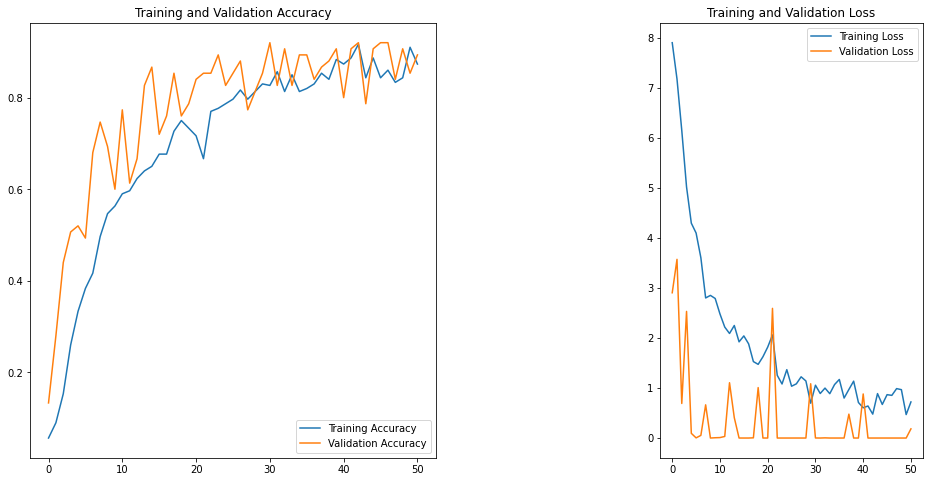

In [19]:
model_acc_val_plot(model)

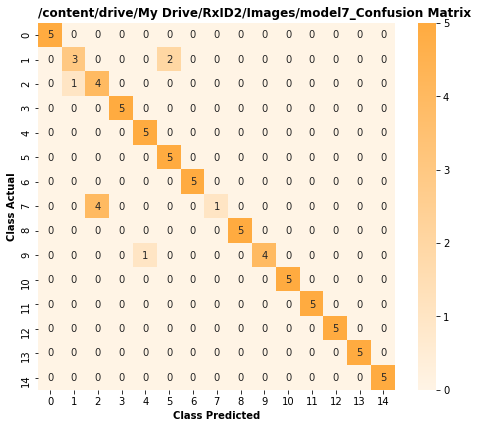

In [0]:
model_confusion(model)

/content/drive/My Drive/RxID2/Data/Download
/content/drive/My Drive/RxID2


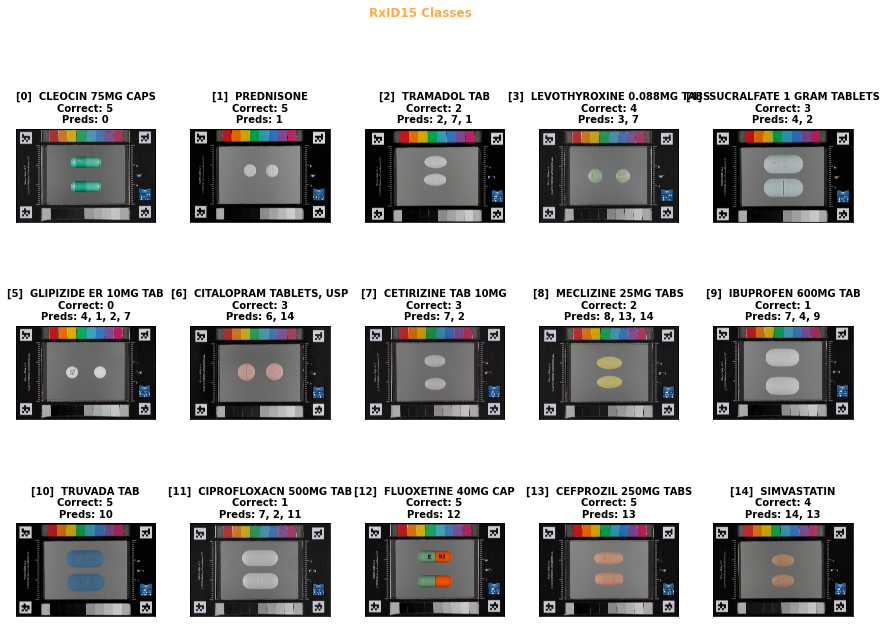

In [0]:
predict_plot(model)